# Dengue
Dengue fever is a mosquito-borne illness that mostly affects tropical and subtropical regions of the world. In mild instances, symptoms are comparable to those of the flu, including fever, rash, and muscle and joint discomfort. It can cause serious bleeding, low blood pressure, and even death in extreme cases.

Dengue transmission dynamics are connected to climatic factors such as temperature and precipitation since it is spread by mosquitos. Although the link to climate is complicated, a rising number of experts suggest that climate change is likely to result in distributional alterations with important public health consequences throughout the world.

## Importing required libraries

In [29]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import seaborn as sns
sns.set()

from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from xgboost import XGBRegressor, plot_importance

from sklearn.experimental import enable_iterative_imputer 

from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer

# 1. Data Ingestion

The study consists of data for two cities: __*San Juan, Puerto Rico*__ and __*Iquitos, , Peru*__

The dataset consists of two parts
* __dengue_features_train.csv__ : Contains readings for all the factors considered in the study (like humidity, temperature, etc.)
* __dengue_labels_train.csv__ : Contains the number of Dengue cases reported on a weekly basis.

In [30]:
env = 'VSCode'#'Colab'
path = '.'

if env == 'Colab':
    from google.colab import drive
    drive.mount('/content/drive')
    !ls drive/MyDrive/Dataset
    path = 'drive/MyDrive'

features = pd.read_csv(f'{path}/Dataset/dengue_features_train.csv', index_col = [0,1,2])
features.week_start_date = pd.to_datetime(features.week_start_date) # Converting the date into a date time object

cases = pd.read_csv(f'{path}/Dataset/dengue_labels_train.csv', index_col = [0,1,2])

# Performing an Inner Join on the dataset on the common columns
df = pd.merge(features, cases, left_index = True, right_index = True)
df.set_index(['week_start_date'], append = True, inplace = True)
df.head()

ndvi_ne   ndvi_nw   ndvi_se   ndvi_sw  \
city year weekofyear week_start_date                                           
sj   1990 18         1990-04-30       0.122600  0.103725  0.198483  0.177617   
          19         1990-05-07       0.169900  0.142175  0.162357  0.155486   
          20         1990-05-14       0.032250  0.172967  0.157200  0.170843   
          21         1990-05-21       0.128633  0.245067  0.227557  0.235886   
          22         1990-05-28       0.196200  0.262200  0.251200  0.247340   

                                      precipitation_amt_mm  \
city year weekofyear week_start_date                         
sj   1990 18         1990-04-30                      12.42   
          19         1990-05-07                      22.82   
          20         1990-05-14                      34.54   
          21         1990-05-21                      15.36   
          22         1990-05-28                       7.52   

                                      reanalysis_air_temp_k  \
city year weekofyear week_start_date                          
sj   1990 18         1990-04-30                  297.572857   
          19         1990-05-07                  298.211429   
          20         1990-05-14                  298.781429   
          21         1990-05-21                  298.987143   
          22         1990-05-28                  299.518571   

                                      reanalysis_avg_temp_k  \
city year weekofyear week_start_date                          
sj   1990 18         1990-04-30                  297.742857   
          19         1990-05-07                  298.442857   
          20         1990-05-14                  298.878571   
          21         1990-05-21                  299.228571   
          22         1990-05-28                  299.664286   

                                      reanalysis_dew_point_temp_k  \
city year weekofyear week_start_date                                
sj   1990 18         1990-04-30                        292.414286   
          19         1990-05-07                        293.951429   
          20         1990-05-14                        295.434286   
          21         1990-05-21                        295.310000   
          22         1990-05-28                        295.821429   

                                      reanalysis_max_air_temp_k  \
city year weekofyear week_start_date                              
sj   1990 18         1990-04-30                           299.8   
          19         1990-05-07                           300.9   
          20         1990-05-14                           300.5   
          21         1990-05-21                           301.4   
          22         1990-05-28                           301.9   

                                      reanalysis_min_air_temp_k  ...  \
city year weekofyear week_start_date                             ...   
sj   1990 18         1990-04-30                           295.9  ...   
          19         1990-05-07                           296.4  ...   
          20         1990-05-14                           297.3  ...   
          21         1990-05-21                           297.0  ...   
          22         1990-05-28                           297.5  ...   

                                      reanalysis_relative_humidity_percent  \
city year weekofyear week_start_date                                         
sj   1990 18         1990-04-30                                  73.365714   
          19         1990-05-07                                  77.368571   
          20         1990-05-14                                  82.052857   
          21         1990-05-21                                  80.337143   
          22         1990-05-28                                  80.460000   

                                      reanalysis_sat_precip_amt_mm  \
city year weekofyear week_start_date                                 
sj   1990 18 

## We do analysis on each city independently since our literature review led us to the conclusion that the spread of Dengue varies by area.

In [31]:
sj_df = df.loc['sj']
sj_df.head()

ndvi_ne   ndvi_nw   ndvi_se   ndvi_sw  \
year weekofyear week_start_date                                           
1990 18         1990-04-30       0.122600  0.103725  0.198483  0.177617   
     19         1990-05-07       0.169900  0.142175  0.162357  0.155486   
     20         1990-05-14       0.032250  0.172967  0.157200  0.170843   
     21         1990-05-21       0.128633  0.245067  0.227557  0.235886   
     22         1990-05-28       0.196200  0.262200  0.251200  0.247340   

                                 precipitation_amt_mm  reanalysis_air_temp_k  \
year weekofyear week_start_date                                                
1990 18         1990-04-30                      12.42             297.572857   
     19         1990-05-07                      22.82             298.211429   
     20         1990-05-14                      34.54             298.781429   
     21         1990-05-21                      15.36             298.987143   
     22         1990-05-28                       7.52             299.518571   

                                 reanalysis_avg_temp_k  \
year weekofyear week_start_date                          
1990 18         1990-04-30                  297.742857   
     19         1990-05-07                  298.442857   
     20         1990-05-14                  298.878571   
     21         1990-05-21                  299.228571   
     22         1990-05-28                  299.664286   

                                 reanalysis_dew_point_temp_k  \
year weekofyear week_start_date                                
1990 18         1990-04-30                        292.414286   
     19         1990-05-07                        293.951429   
     20         1990-05-14                        295.434286   
     21         1990-05-21                        295.310000   
     22         1990-05-28                        295.821429   

                                 reanalysis_max_air_temp_k  \
year weekofyear week_start_date                              
1990 18         1990-04-30                           299.8   
     19         1990-05-07                           300.9   
     20         1990-05-14                           300.5   
     21         1990-05-21                           301.4   
     22         1990-05-28                           301.9   

                                 reanalysis_min_air_temp_k  ...  \
year weekofyear week_start_date                             ...   
1990 18         1990-04-30                           295.9  ...   
     19         1990-05-07                           296.4  ...   
     20         1990-05-14                           297.3  ...   
     21         1990-05-21                           297.0  ...   
     22         1990-05-28                           297.5  ...   

                                 reanalysis_relative_humidity_percent  \
year weekofyear week_start_date                                         
1990 18         1990-04-30                                  73.365714   
     19         1990-05-07                                  77.368571   
     20         1990-05-14                                  82.052857   
     21         1990-05-21                                  80.337143   
     22         1990-05-28                                  80.460000   

                                 reanalysis_sat_precip_amt_mm  \
year weekofyear week_start_date                                 
1990 18         1990-04-30                              12.42   
     19         1990-05-07                              22.82   
     20         1990-05-14                              34.54   
     21         1990-05-21                              15.36   
     22         1990-05-28                               7.52   

                                 reanalysis_specific_humidity_g_per_kg  \
year weekofyear week_start_date                                          
1990 18         1990-04-30                                   14.012857

In [32]:
iq_df = df.loc['iq']
iq_df.head()

ndvi_ne   ndvi_nw   ndvi_se   ndvi_sw  \
year weekofyear week_start_date                                           
2000 26         2000-07-01       0.192886  0.132257  0.340886  0.247200   
     27         2000-07-08       0.216833  0.276100  0.289457  0.241657   
     28         2000-07-15       0.176757  0.173129  0.204114  0.128014   
     29         2000-07-22       0.227729  0.145429  0.254200  0.200314   
     30         2000-07-29       0.328643  0.322129  0.254371  0.361043   

                                 precipitation_amt_mm  reanalysis_air_temp_k  \
year weekofyear week_start_date                                                
2000 26         2000-07-01                      25.41             296.740000   
     27         2000-07-08                      60.61             296.634286   
     28         2000-07-15                      55.52             296.415714   
     29         2000-07-22                       5.60             295.357143   
     30         2000-07-29                      62.76             296.432857   

                                 reanalysis_avg_temp_k  \
year weekofyear week_start_date                          
2000 26         2000-07-01                  298.450000   
     27         2000-07-08                  298.428571   
     28         2000-07-15                  297.392857   
     29         2000-07-22                  296.228571   
     30         2000-07-29                  297.635714   

                                 reanalysis_dew_point_temp_k  \
year weekofyear week_start_date                                
2000 26         2000-07-01                        295.184286   
     27         2000-07-08                        295.358571   
     28         2000-07-15                        295.622857   
     29         2000-07-22                        292.797143   
     30         2000-07-29                        293.957143   

                                 reanalysis_max_air_temp_k  \
year weekofyear week_start_date                              
2000 26         2000-07-01                           307.3   
     27         2000-07-08                           306.6   
     28         2000-07-15                           304.5   
     29         2000-07-22                           303.6   
     30         2000-07-29                           307.0   

                                 reanalysis_min_air_temp_k  ...  \
year weekofyear week_start_date                             ...   
2000 26         2000-07-01                           293.1  ...   
     27         2000-07-08                           291.1  ...   
     28         2000-07-15                           292.6  ...   
     29         2000-07-22                           288.6  ...   
     30         2000-07-29                           291.5  ...   

                                 reanalysis_relative_humidity_percent  \
year weekofyear week_start_date                                         
2000 26         2000-07-01                                  92.418571   
     27         2000-07-08                                  93.581429   
     28         2000-07-15                                  95.848571   
     29         2000-07-22                                  87.234286   
     30         2000-07-29                                  88.161429   

                                 reanalysis_sat_precip_amt_mm  \
year weekofyear week_start_date                                 
2000 26         2000-07-01                              25.41   
     27         2000-07-08                              60.61   
     28         2000-07-15                              55.52   
     29         2000-07-22                               5.60   
     30         2000-07-29                              62.76   

                                 reanalysis_specific_humidity_g_per_kg  \
year weekofyear week_start_date                                          
2000 26         2000-07-01                                   16.651429

In [33]:
cities = {
    "San Juan" : {
        'data' : sj_df,
        'models' : {}
    },
    "Iquitos" : {
        'data' : iq_df,
        'models' : {}
    }
}
for city in cities:
    print(f"Shape of {city}'s data = {cities[city]['data'].shape}")

Shape of San Juan's data = (936, 21)
Shape of Iquitos's data = (520, 21)


## Negative Binomial Regression (Benchmark)

In [34]:
from statsmodels.tools import eval_measures
import statsmodels.formula.api as smf
import statsmodels.api as sm

def get_best_model(train, test):
    # Model Specification
    model_formula = "total_cases ~ 1 + " \
                    "reanalysis_specific_humidity_g_per_kg + " \
                    "reanalysis_dew_point_temp_k + " \
                    "station_min_temp_c + " \
                    "station_avg_temp_c"
    
    grid = 10 ** np.arange(-8, -3, dtype=np.float64)
                    
    best_alpha = []
    best_score = 1000
        
    # Grid search to find optimal value for alpha
    for alpha in grid:
        model = smf.glm(formula=model_formula,
                        data=train,
                        family=sm.families.NegativeBinomial(alpha=alpha))

        results = model.fit()
        predictions = results.predict(test).astype(int)
        score = eval_measures.meanabs(predictions, test.total_cases)
        mse = eval_measures.mse(predictions, test.total_cases)

        if score < best_score:
            best_alpha = alpha
            best_score = score
            best_mse = mse

    print('Best alpha = ', best_alpha)
    print('MAE = ', best_score)
    print('MSE = ', best_mse)
            
    # Refitting on entire dataset
    full_dataset = pd.concat([train, test])
    model = smf.glm(formula=model_formula,
                    data=full_dataset,
                    family=sm.families.NegativeBinomial(alpha=best_alpha))

    fitted_model = model.fit()
    return fitted_model

In [35]:
sjDfBin = sj_df.fillna(method='ffill')
iqDfBin = iq_df.fillna(method='ffill')

sjPart = 800
sj_train_subtrain = sjDfBin.head(sjPart)
sj_train_subtest = sjDfBin.tail(sjDfBin.shape[0] - sjPart)

iqPart = 400
iq_train_subtrain = iqDfBin.head(iqPart)
iq_train_subtest = iqDfBin.tail(iqDfBin.shape[0] - iqPart)

print('San Juan')
cities['San Juan']['models']['Negative Binomial Regression'] = get_best_model(sj_train_subtrain, sj_train_subtest)

print('\nIquitos')
cities['Iquitos']['models']['Negative Binomial Regression'] = get_best_model(iq_train_subtrain, iq_train_subtest)

San Juan
Best alpha =  1e-08
MAE =  22.080882352941178
MSE =  756.9779411764706

Iquitos
Best alpha =  1e-08
MAE =  6.466666666666667
MSE =  119.31666666666666


## XGBoost

In [36]:
trainDfiq = iq_df
trainDfsj = sj_df

In [37]:
def train(df, part):
    unwantedCols = ['month', 'week_start_date', 'year', 'weekofyear', 'week_start_date', 'city', 'total_cases', "Negative Binomial Regression", "XGBoost"]

    trainDf = df.head(part)
    valDf = df.tail(df.shape[0] - part)


    x = trainDf.drop(unwantedCols, axis = 1, errors = 'ignore')
    y = trainDf['total_cases']

    # Parameters for Grid Search
    param_grid = dict(
        pca__n_components = list(range(10, 22)),
        preprocessor = [MinMaxScaler(), RobustScaler(), StandardScaler()]
    )

    xgbModel = XGBRegressor(
        random_state = 1, 
        n_estimators = 500, 
        learning_rate = 0.1
    )

    xgbPipeline = Pipeline(
        steps = [
            ('imputer',  KNNImputer(missing_values=np.nan)),
            ('preprocessor', RobustScaler()),
            ('pca', PCA(n_components = 15)),
            ('model', xgbModel)
        ]
    )

    grid = GridSearchCV(xgbPipeline, param_grid = param_grid, cv = 4, verbose = 3)
    grid.fit(x, y)
    print("\nBest Model:")
    print(grid.best_estimator_)

    xgbPipeline = grid.best_estimator_

    predictions = xgbPipeline.predict(valDf.drop(unwantedCols, axis = 1, errors = 'ignore')).astype(int)
 
    print("MAE = ", eval_measures.meanabs(predictions, valDf.total_cases))
    print("MSE = ", eval_measures.mse(predictions, valDf.total_cases))

    f, ax = plt.subplots(figsize=(20, 5))

    plot_importance(xgbPipeline.steps[-1][1].get_booster(), ax = ax)
    plt.show()

    return xgbPipeline.fit(df.drop(unwantedCols, axis = 1, errors = 'ignore'), df.total_cases)

Fitting 4 folds for each of 36 candidates, totalling 144 fits
[CV 1/4] END pca__n_components=10, preprocessor=MinMaxScaler();, score=-1.284 total time=   1.3s
[CV 2/4] END pca__n_components=10, preprocessor=MinMaxScaler();, score=-0.072 total time=   1.9s
[CV 3/4] END pca__n_components=10, preprocessor=MinMaxScaler();, score=-0.219 total time=   1.4s
[CV 4/4] END pca__n_components=10, preprocessor=MinMaxScaler();, score=-4.000 total time=   1.6s
[CV 1/4] END pca__n_components=10, preprocessor=RobustScaler();, score=-2.456 total time=   1.4s
[CV 2/4] END pca__n_components=10, preprocessor=RobustScaler();, score=-0.110 total time=   2.0s
[CV 3/4] END pca__n_components=10, preprocessor=RobustScaler();, score=-0.204 total time=   2.5s
[CV 4/4] END pca__n_components=10, preprocessor=RobustScaler();, score=-2.881 total time=   2.6s
[CV 1/4] END pca__n_components=10, preprocessor=StandardScaler();, score=-4.220 total time=   2.3s
[CV 2/4] END pca__n_components=10, preprocessor=StandardScaler(

/home/dhruval/miniconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
12 fits failed out of a total of 144.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
12 fits failed with the following error:
Traceback (most recent call last):
  File "/home/dhruval/miniconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/dhruval/miniconda3/lib/python3.9/site-packages/sklearn/pipeline.py", line 390, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "/home/dhruval/miniconda3/lib/python3.9/site-packages/sklearn/pipeline.py", line 348, in _fit
    X, fitted_transformer = fit_transform_o


Best Model:
Pipeline(steps=[('imputer', KNNImputer()), ('preprocessor', MinMaxScaler()),
                ('pca', PCA(n_components=17)),
                ('model',
                 XGBRegressor(base_score=0.5, booster='gbtree',
                              colsample_bylevel=1, colsample_bynode=1,
                              colsample_bytree=1, enable_categorical=False,
                              gamma=0, gpu_id=-1, importance_type=None,
                              interaction_constraints='', learning_rate=0.1,
                              max_delta_step=0, max_depth=6, min_child_weight=1,
                              missing=nan, monotone_constraints='()',
                              n_estimators=500, n_jobs=4, num_parallel_tree=1,
                              predictor='auto', random_state=1, reg_alpha=0,
                              reg_lambda=1, scale_pos_weight=1, subsample=1,
                              tree_method='exact', validate_parameters=1,
                   

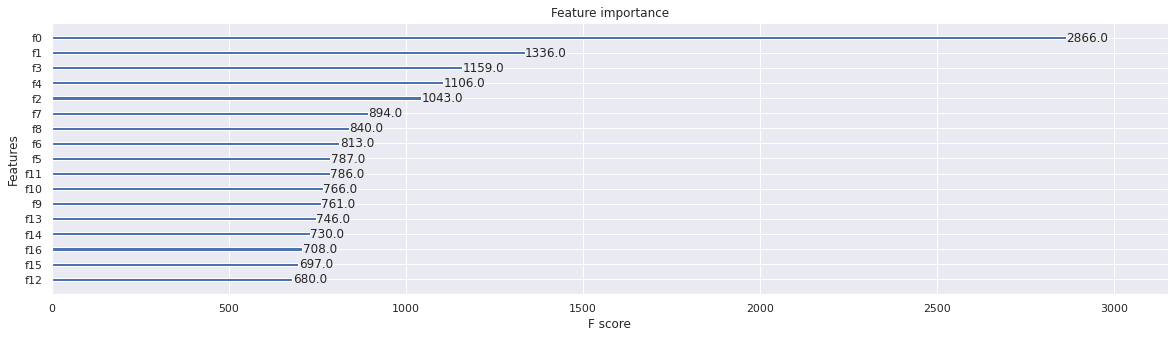

In [38]:
cities['San Juan']['models']['XGBoost'] = train(sj_df, sjPart)

Fitting 4 folds for each of 36 candidates, totalling 144 fits
[CV 1/4] END pca__n_components=10, preprocessor=MinMaxScaler();, score=-1.572 total time=   0.8s
[CV 2/4] END pca__n_components=10, preprocessor=MinMaxScaler();, score=-1.013 total time=   0.6s
[CV 3/4] END pca__n_components=10, preprocessor=MinMaxScaler();, score=-0.143 total time=   0.9s
[CV 4/4] END pca__n_components=10, preprocessor=MinMaxScaler();, score=-0.123 total time=   0.6s
[CV 1/4] END pca__n_components=10, preprocessor=RobustScaler();, score=-1.535 total time=   0.8s
[CV 2/4] END pca__n_components=10, preprocessor=RobustScaler();, score=-0.815 total time=   1.0s
[CV 3/4] END pca__n_components=10, preprocessor=RobustScaler();, score=-0.261 total time=   0.9s
[CV 4/4] END pca__n_components=10, preprocessor=RobustScaler();, score=-0.552 total time=   0.8s
[CV 1/4] END pca__n_components=10, preprocessor=StandardScaler();, score=-1.304 total time=   0.7s
[CV 2/4] END pca__n_components=10, preprocessor=StandardScaler(

/home/dhruval/miniconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
12 fits failed out of a total of 144.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
12 fits failed with the following error:
Traceback (most recent call last):
  File "/home/dhruval/miniconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/dhruval/miniconda3/lib/python3.9/site-packages/sklearn/pipeline.py", line 390, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "/home/dhruval/miniconda3/lib/python3.9/site-packages/sklearn/pipeline.py", line 348, in _fit
    X, fitted_transformer = fit_transform_o


Best Model:
Pipeline(steps=[('imputer', KNNImputer()), ('preprocessor', MinMaxScaler()),
                ('pca', PCA(n_components=14)),
                ('model',
                 XGBRegressor(base_score=0.5, booster='gbtree',
                              colsample_bylevel=1, colsample_bynode=1,
                              colsample_bytree=1, enable_categorical=False,
                              gamma=0, gpu_id=-1, importance_type=None,
                              interaction_constraints='', learning_rate=0.1,
                              max_delta_step=0, max_depth=6, min_child_weight=1,
                              missing=nan, monotone_constraints='()',
                              n_estimators=500, n_jobs=4, num_parallel_tree=1,
                              predictor='auto', random_state=1, reg_alpha=0,
                              reg_lambda=1, scale_pos_weight=1, subsample=1,
                              tree_method='exact', validate_parameters=1,
                   

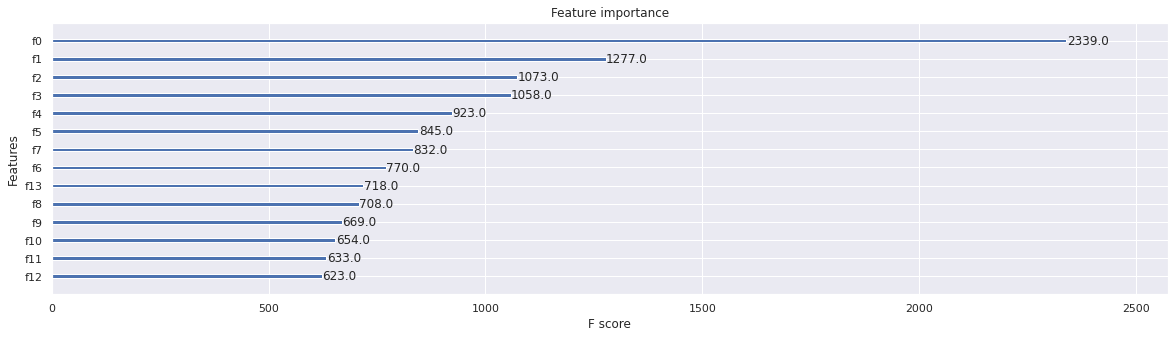

In [39]:
cities['Iquitos']['models']['XGBoost'] = train(iq_df, iqPart)

## Comparing the Models

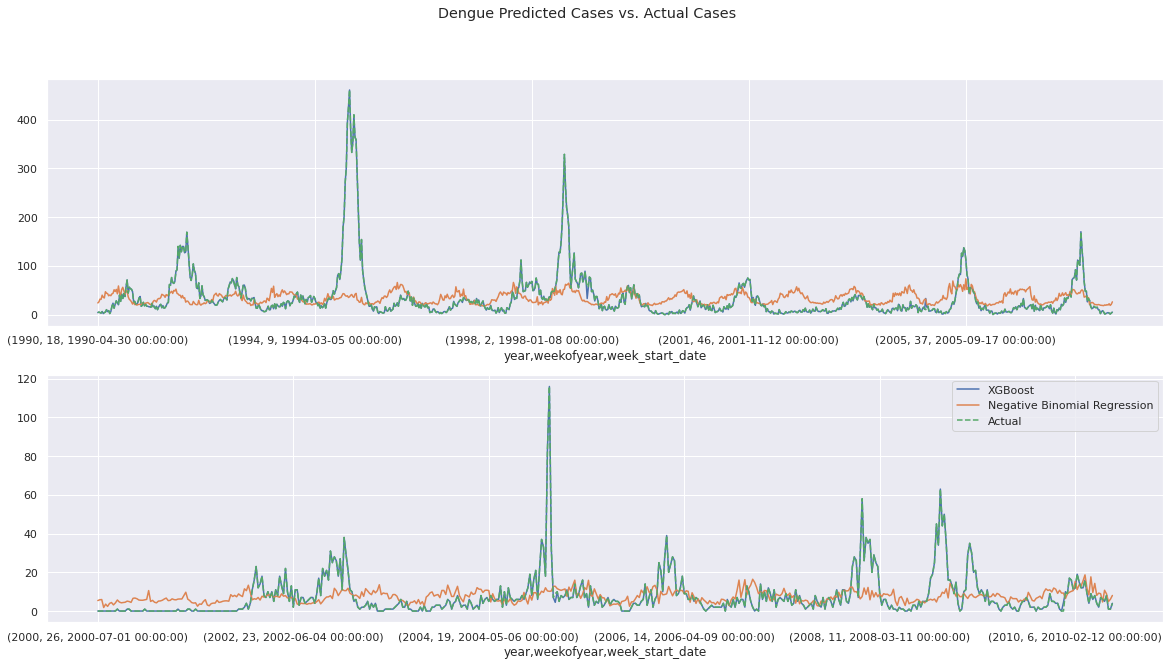

In [40]:
pd.options.mode.chained_assignment = None 
unwantedCols = ['month', 'week_start_date', 'year', 'weekofyear', 'week_start_date', 'city', 'total_cases', "Negative Binomial Regression", "XGBoost"]
figs, axes = plt.subplots(nrows=2, ncols=1, figsize = (20, 10))

for index, city in enumerate(cities):
    for model in cities[city]['models']:
        if model == 'Negative Binomial Regression': continue
        cities[city]['data'][model] = cities[city]['models'][model].predict(cities[city]['data'].drop(unwantedCols, axis = 1, errors = 'ignore'))
        cities[city]['data'][model].plot(ax = axes[index], label = model)
    cities[city]['data']['Negative Binomial Regression'] = cities[city]['models']['Negative Binomial Regression'].fittedvalues
    cities[city]['data']['Negative Binomial Regression'].plot(ax = axes[index], label = "Negative Binomial Regression")
    cities[city]['data'].total_cases.plot(ax = axes[index], label = "Actual", style='--')

plt.suptitle("Dengue Predicted Cases vs. Actual Cases")
plt.legend()
plt.show()